# Test Flight Clustering

One of the problems is that all the test flights are in seperate data groupings so each flight test needs to be brought in and cleaned seperately. However, this is costly and requires comparitavely large amounts of memory and time when compared with model training. Both test flight conglomeration as well as test flight training a sequencies of flight tests require some sort of measurement between datasets to determine optimal training scheduling. It is somewhat unclear on how to do this as there is no natural metric so some various ways are presented.

## Methods

Broadly speaking, there are two types of methods being investigated in this notebook:

1. Covariance/Entropy methods
2. Loss Function methods

The covariance and entropy methods are fairly classical methods from Information Theory. Generating a covariance matrix $\Sigma$ is fairly easy for uniform discrete time-series and can be used to estimiate maximal bounds on multivariate entropy which can then be used to calculate amounts information that exists in input and output spaces of the flight tests as well as mutual information between flight tests. There are downsides to covariance and entropy calculations and that is the size of memory required to store that much information. This leads to a proposed type of methods called Loss Function methods. Generally speaking, Loss Function methods use trained neural networks and their evaluated loss function over datasets to determine distances between datasets. This is based on the idea that neural networks can be thought of compressed representations of set-set functions or that the neural networks are learning some [kernel representation](https://arxiv.org/abs/2012.00152) as summarly explained [here](https://www.youtube.com/watch?v=ahRPdiCop3E). Manipulating the loss function outputs, it may be possible to have some sort of distance notion between datasets and the ability to learn desired functional outputs.


## Input/Output Standardization

The test flight datasets are all coming from the Blackbird Dataset and have been standardized of an optimal controller with input and output sensors downsampled to 10 Hz for periods of 1 second. Hence for the $i$th test flight dataset $\mathcal{D}_i = (\mathcal{X}, \mathcal{Y})$ has $N$ samples of the input set $\mathcal{X} = \lbrace \mathbf{X}_j| \mathbf{X}_j \in \mathbb{R}^{240},\ j=1,\cdots,N \rbrace$ and the corresponding output set $\mathcal{Y} = \lbrace \mathbf{Y}_j| \mathbf{Y}_j \in \mathbb{R}^{40},\ j=1,\cdots,N \rbrace$.


## Modules

Load in the desired python libraries and set up the working directory.


In [1]:
import igraph as ig  # Graph for visualizations
import numpy as np  # for numerical manipulations
import os  # manipulate path
import sys
import tensorflow as tf  # Manipulate tensorflow neural networks
from thesis.data import blackbird_dataset as rbd  # Flight test list
from thesis.models import train_optimal_controller as toc  # Generating default neural networks used

## Covariance Methods

The covariance methods rely on the covariance matrices $\Sigma$ which are symmetric, positive-definite matrices formed by $\Sigma_{\mathbf{X}\mathbf{X}} = \mathbb{E}\left[(\mathbf{X} - \mathbb{E}[\mathbf{X}]) (\mathbf{X} - \mathbb{E}[\mathbf{X}])^T \right]$ with $\mathbf{X} \in \mathbb{R}^{n}$ and a column random variable vector. With time series, generally the history vector $\mathbf{X}_h \in \mathbb{R}^{n\times r}$ of $\mathbf{X}$ is $n$ samplings of a $r$ dimensional space so the covariance matrix can be estimated by $\Sigma_{\mathbf{X}\mathbf{X}} = \mathbf{X}_h^T \mathbf{X}_h /(n - 1) - n \mathbb{E}[\mathbf{X}]\mathbb{E}[\mathbf{X}^T]/(n-1)$. Expanding covariance to the cross-covariance of two random vectors, both in $\mathbb{R}^r$, with the same $n$ samples as $\Sigma_{\mathbf{X}\mathbf{Y}} = \mathbf{X}_h^T \mathbf{Y}_h /(n - 1) - n \mathbb{E}[\mathbf{X}]\mathbb{E}[\mathbf{Y}^T]/(n-1)$. Using the covariance matrices, the differential entropy as maximized by the multivariate gaussian distribution is $h(\mathbf{X}) = \frac{1}{2}\ln(2\pi e \det(\Sigma_{\mathbf{X}\mathbf{X}})) $ which can be used as a measure information stored in the dataset. With information being a notion, the mutual information can also be defined as $I(\mathbf{X};\mathbf{Y}) = h(\mathbf{Y}) - h(\mathbf{Y}|\mathbf{X}) = h(\mathbf{X}) - h(\mathbf{X}|\mathbf{Y})$ where $h(\mathbf{Y}|\mathbf{X})$ is based on the posterior covariance matrix $\Sigma_{\mathbf{Y}|\mathbf{X}} = \Sigma_{\mathbf{YY}} - \Sigma_{\mathbf{XY}}^T \Sigma_{\mathbf{XX}}^{-1}\Sigma_{\mathbf{XY}}$.

One of the fundamental issues with doing covariance between datasets is that $\mathcal{D}_i$ and $\mathcal{D}_j$ have different number of samples. One of the ways is to potentially rescale the inputs and outputs and approximate but since the optimal controller is based off of time windows, the two datasets cannot be rescales. Instead, both inputs and outputs have an associated time vector so let $t_k' = t_k - \bar{t}_k$ be the time vector centered around the middle of the maneuver and, without loss of generality, let $|\mathcal{D}_i| = N < M = |\mathcal{D}_j|$. Construct a downsample dataset $\mathcal{D}'_j = \lbrace (\mathbf{X}_j, \mathbf{Y}_j) | (\mathbf{X}_j, \mathbf{Y}_j)\in\mathcal{D}_j,\ \min_{t_j} |t'_i - t'_j|\ \forall i = 1,\cdots,N \rbrace$ and then constrct the cross-covariance matrices $\Sigma_{\mathbf{X}_i \mathbf{X}'_j}$ and $\Sigma_{\mathbf{Y}_i \mathbf{Y}'_j}$ and this can be used to find cross-entropy and mutual information between datasets $\mathcal{D}_i$ and $\mathcal{D}_j$.

In [2]:
def h(Sigma):
    # Occasionally det(Sigma_{X|Y}) < 0 so just switch the value
    return 0.5*np.log(2.*np.pi*np.exp(1)*np.abs(np.linalg.det(Sigma)))

def post_covar(Sxx, Sxy, Syy):
    return Sxx - (Sxy @ np.linalg.inv(Syy) @ Sxy)

def mutual_information(Sxx, Sxy, Syy):
    return h(Sxx) - h(post_covar(Sxx, Sxy, Syy))

In [3]:
test_index = [0, 2, 3, 4, 6, 7, 8, 9, 10]  # First 10 valid flight tests for constructing graph

# Printing the flight tests
for ti in test_index:
    print(rbd.TEST_FLIGHT_LIST[ti])

('ampersand', 'Forward', 1.0)
('bentDice', 'Forward', 0.5)
('bentDice', 'Forward', 1.0)
('bentDice', 'Forward', 2.0)
('clover', 'Forward', 0.5)
('clover', 'Forward', 1.0)
('clover', 'Forward', 2.0)
('clover', 'Forward', 3.0)
('clover', 'Forward', 4.0)


In [4]:
# Construct the graph
color_dict = {
    "ampersand": "red",
    "bentDice": "blue",
    "clover": "green"
}

g = ig.Graph.Full(n=len(test_index))
g.es["weight"] = 1.
g.vs["Maneuver"] = [rbd.TEST_FLIGHT_LIST[ti][0] for ti in test_index]
g.vs["Speed"] = [rbd.TEST_FLIGHT_LIST[ti][2] for ti in test_index]
g.vs["color"] = [color_dict[maneuver] for maneuver in g.vs["Maneuver"]]

In [5]:
input_cov_filename = (
    r'../report/distances/covariance/' +
    'input_covariance_%i-%i.npy'
)

# Calculate edge weights based on mutual information
for e in g.es:
    tf1, tf2 = e.source, e.target
    tf1, tf2 = test_index[tf1], test_index[tf2]
    Sxx = np.load(input_cov_filename % (tf1, tf1))
    Sxy = np.load(input_cov_filename % (tf1, tf2))
    Syy = np.load(input_cov_filename % (tf2, tf2))
    try:
        e["weight"] = mutual_information(Sxx, Sxy, Syy)
    except:
        print("Problem with %i-%i" % (tf1, tf2))
        print(Sxx.shape, Sxy.shape, Syy.shape)
        e["weight"] = 0.
        
    if np.isnan(e["weight"]):
        print("Problem with %i-%i" % (tf1, tf2))
        if np.any(np.isnan(Sxx)):
            print("Issue with S_%i-%i" % (tf1, tf1))
        if np.any(np.isnan(Sxy)):
            print("Issue with S_%i-%i" % (tf1, tf2))
        if np.any(np.isnan(Syy)):
            print("Issue with S_%i-%i" % (tf2, tf2))
        print(
            np.linalg.det(Sxx),
            np.linalg.det(Sxy),
            np.linalg.det(Syy),
            np.linalg.det(post_covar(Sxx, Sxy, Syy))
        )

Problem with 0-2
0.0 nan nan nan
Problem with 0-3

C:\Users\Patrick\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Patrick\AppData\Roaming\Python\Python37\site-packages\numpy\linalg\linalg.py:2093: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
C:\Users\Patrick\AppData\Roaming\Python\Python37\site-packages\numpy\linalg\linalg.py:2093: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)



0.0 nan nan nan
Problem with 0-4
0.0 nan nan nan
Problem with 0-6
0.0 nan nan nan
Problem with 0-7
0.0 nan nan nan
Problem with 0-8
0.0 nan nan nan
Problem with 0-9
0.0 nan nan nan
Problem with 0-10
0.0 nan nan nan
Problem with 2-3
nan nan nan nan
Problem with 2-4
nan nan nan nan
Problem with 2-6
nan nan nan nan
Problem with 2-7
nan nan nan nan
Problem with 2-8
nan nan nan nan
Problem with 2-9
nan nan nan nan
Problem with 2-10
nan nan nan nan
Problem with 3-4
nan nan nan nan
Problem with 3-6
nan nan nan nan
Problem with 3-7
nan nan nan nan
Problem with 3-8
nan nan nan nan
Problem with 3-9
nan nan nan nan
Problem with 3-10
nan nan nan nan
Problem with 4-6
nan nan nan nan
Problem with 4-7
nan nan nan nan
Problem with 4-8
nan nan nan nan
Problem with 4-9
nan nan nan nan
Problem with 4-10
nan nan nan nan
Problem with 6-7
nan nan nan nan
Problem with 6-8
nan nan nan nan
Problem with 6-9
nan nan nan nan
Problem with 6-10
nan nan nan nan
Problem with 7-8
nan nan nan nan
Problem with 7-9
nan 

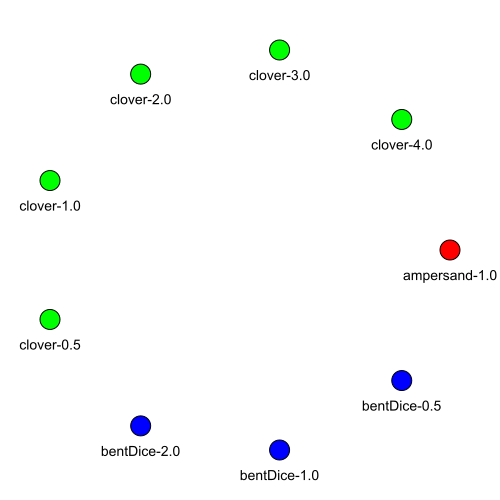

In [6]:
# Setting up plotting characteristics
g.vs["label"] = [v["Maneuver"] + "-" + str(v["Speed"]) for v in g.vs]

# Plotting the resulting graph
layout = g.layout_circle()
ig.plot(
    g, layout=layout, bbox=(500,500),
    **{
        'edge_width': g.es["weight"],
        'margin': 50,
        'vertex_label_dist': 2,
    }
)

In [7]:
output_cov_filename = (
    r'../report/distances/covariance/' +
    'output_covariance_%i-%i.npy'
)

# Calculate edge weights based on mutual information
for e in g.es:
    tf1, tf2 = e.source, e.target
    tf1, tf2 = test_index[tf1], test_index[tf2]
    Sxx = np.load(output_cov_filename % (tf1, tf1))
    Sxy = np.load(output_cov_filename % (tf1, tf2))
    Syy = np.load(output_cov_filename % (tf2, tf2))
    try:
        e["weight"] = mutual_information(Sxx, Sxy, Syy)
    except:
        print("Problem with %i-%i" % (tf1, tf2))
        print(Sxx.shape, Sxy.shape, Syy.shape)
        e["weight"] = 0.
        
    if np.isnan(e["weight"]):
        print("Problem with %i-%i" % (tf1, tf2))
        if np.any(np.isnan(Sxx)):
            print("Issue with S_%i-%i" % (tf1, tf1))
        if np.any(np.isnan(Sxy)):
            print("Issue with S_%i-%i" % (tf1, tf2))
        if np.any(np.isnan(Syy)):
            print("Issue with S_%i-%i" % (tf2, tf2))
        print(
            np.linalg.det(Sxx),
            np.linalg.det(Sxy),
            np.linalg.det(Syy),
            np.linalg.det(post_covar(Sxx, Sxy, Syy))
        )

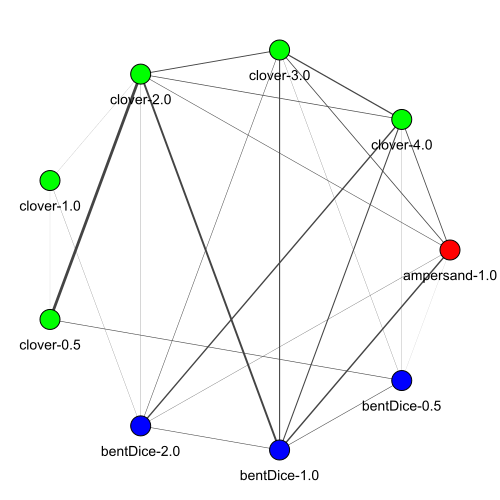

In [8]:
# Setting up plotting characteristics
g.vs["label"] = [v["Maneuver"] + "-" + str(v["Speed"]) for v in g.vs]

# Plotting the resulting graph
layout = g.layout_circle()
ig.plot(
    g, layout=layout, bbox=(500,500),
    **{
        'edge_width': g.es["weight"],
        'margin': 50,
        'vertex_label_dist': 2,
    }
)

## Loss Function Methods

Loss function methods are unlike classical measurements of information relies not the data itself but rather learned representations of the data. Given the dataset $\mathcal{D}_i$ and having it as a function $\mathcal{D}_i:\mathcal{X}_i \mapsto \mathcal{Y}_i$, neural networks are trained to find the approximate function $\hat{f}_i =  \min_{f} \mathcal{L}(f(\mathcal{X}_i), \mathcal{Y}_i)$ where $\mathcal{L}$ is a loss function which is a metric of the networks outputs from the labeled true outputs. When talking about multiple datasets, it may be necessary to consider concatination of datasets $\mathcal{D}_{i,j} = \mathcal{D}_i \cup \mathcal{D}_j$ to find an approximation to some underlying unified function $\hat{f}_{i,j}$ if it exists. Some properties that you will have is that $\mathcal{L}(\hat{f}_i(\mathcal{X}_i), \mathcal{Y}_i) \leq \mathcal{L}(\hat{f}_{i,j}(\mathcal{X}_i), \mathcal{Y}_i)$ and $\mathcal{L}(\hat{f}_j(\mathcal{X}_j), \mathcal{Y}_j) \leq \mathcal{L}(\hat{f}_{i,j}(\mathcal{X}_j), \mathcal{Y}_j)$ as both $\hat{f}_i$ and $\hat{f}_j$ are overfitted to their respectively trained datasets compared to the combined set. However, we also have the following properties $\mathcal{L}(\hat{f}_{i,j}(\mathcal{X}_i), \mathcal{Y}_i) \leq \mathcal{L}(\hat{f}_j(\mathcal{X}_i), \mathcal{Y}_i)$ since $\hat{f}_{i,j}$ has at least seen $\mathcal{D}_i$ and has gleaned information and structure while $\hat{f}_j$ has not. With both upper and lower bounds on the loss function output of the unified function, we can glean that $$ \mathcal{L}(\hat{f}_{i}(\mathcal{X}_i), \mathcal{Y}_i) + \mathcal{L}(\hat{f}_{j}(\mathcal{X}_j), \mathcal{Y}_j) \leq \mathcal{L}(\hat{f}_{i,j}(\mathcal{X}_i), \mathcal{Y}_i) + \mathcal{L}(\hat{f}_{i,j}(\mathcal{X}_j), \mathcal{Y}_j) \leq \mathcal{L}(\hat{f}_{j}(\mathcal{X}_i), \mathcal{Y}_i) + \mathcal{L}(\hat{f}_{i}(\mathcal{X}_j), \mathcal{Y}_j)$$ which can be normalized by $\mathcal{L}(\hat{f}_{i}(\mathcal{X}_i), \mathcal{Y}_i) + \mathcal{L}(\hat{f}_{j}(\mathcal{X}_j), \mathcal{Y}_j)$ while $\left(\dfrac{\mathcal{L}(\hat{f}_{j}(\mathcal{X}_i), \mathcal{Y}_i) + \mathcal{L}(\hat{f}_{i}(\mathcal{X}_j), \mathcal{Y}_j)}{\mathcal{L}(\hat{f}_{i}(\mathcal{X}_i), \mathcal{Y}_i) + \mathcal{L}(\hat{f}_{j}(\mathcal{X}_j), \mathcal{Y}_j)} - 1 \right)$ forms a dataset metric. There are a couple immediate applications.

1. Given multiple datasets used to train a single neural network, you can determine the optimal strict subset for training that best represents the aggregate dataset.
2. Clustering of datasets to form task groups to determine things like number of controllers for autonomous vehicles.
3. Verification of dataset quality.

In [9]:
# Generate adjacency matrix for test flights and load in recorded MSE loss function for the test flights. Invalid is nan
N_test_flights = len(rbd.TEST_FLIGHT_LIST)

mse_h_file = r"../report/distances/nn_distance/tf%i_MSE.npy"
raw_adj_matrix = np.zeros((N_test_flights, N_test_flights))
for i in range(N_test_flights):
    try:
        raw_adj_matrix[i] = np.load(mse_h_file % i)
    except:
        raw_adj_matrix[i,:] = np.nan

In [28]:
# Eliminate test flights where not able to generate valid test data
valid_tf_list = np.any(np.isfinite(raw_adj_matrix), axis=1)
valid_tf_indices = np.arange(N_test_flights)[valid_tf_list]
valid_tf_list = [rbd.TEST_FLIGHT_LIST[tfi] for tfi in valid_tf_indices]
adj_matrix = raw_adj_matrix[valid_tf_indices][:,valid_tf_indices]
print("Any nan's in adjacency matrix:", "Yes" if np.any(np.isnan(adj_matrix)) else "No")
assert adj_matrix.shape[0] == adj_matrix.shape[1]
print("Number of valid test flights: %i" % len(valid_tf_list))
print(valid_tf_list)

Any nan's in adjacency matrix: No
Number of valid test flights: 158
[('ampersand', 'Forward', 1.0), ('ampersand', 'Forward', 2.0), ('bentDice', 'Forward', 0.5), ('bentDice', 'Forward', 1.0), ('bentDice', 'Forward', 2.0), ('bentDice', 'Forward', 3.0), ('clover', 'Forward', 0.5), ('clover', 'Forward', 1.0), ('clover', 'Forward', 2.0), ('clover', 'Forward', 3.0), ('clover', 'Forward', 4.0), ('clover', 'Forward', 5.0), ('dice', 'Forward', 1.0), ('dice', 'Forward', 2.0), ('dice', 'Forward', 3.0), ('halfMoon', 'Forward', 1.0), ('halfMoon', 'Forward', 2.0), ('halfMoon', 'Forward', 3.0), ('halfMoon', 'Forward', 4.0), ('mouse', 'Forward', 1.0), ('mouse', 'Forward', 2.0), ('mouse', 'Forward', 3.0), ('mouse', 'Forward', 4.0), ('mouse', 'Forward', 5.0), ('mouse', 'Forward', 6.0), ('mouse', 'Forward', 7.0), ('oval', 'Forward', 1.0), ('oval', 'Forward', 2.0), ('oval', 'Forward', 3.0), ('oval', 'Forward', 4.0), ('patrick', 'Forward', 0.5), ('patrick', 'Forward', 1.0), ('patrick', 'Forward', 2.0), ('p

In [11]:
# Construct the metric in adjacency
adj_matrix = adj_matrix + adj_matrix.T # Note diagonals are double counted
for i in range(adj_matrix.shape[0]):
    for j in range(adj_matrix.shape[1]):
        if i == j:
            continue
        else:
            # Note: these models are not optimally trained so metric calculated would be < 1
            adj_matrix[i,j] = 2.*adj_matrix[i,j]/(adj_matrix[i,i] + adj_matrix[j,j])

# Diagonal to zero
for i in range(adj_matrix.shape[0]):
    adj_matrix[i,i] = 0.

for adj in adj_matrix:
    print(adj)

[  0.           3.8288071    1.21275271   1.23156341   1.15480549
   3.19527032   1.19412458   1.11191774   1.1675226    1.15243203
   1.08672478   1.52021283   1.20193124   1.22783761   6.30522377
   1.13354015   1.0654337    1.81140365   2.14491541   1.13129176
   1.10685675   1.10151252   1.07776946   0.98421325   1.03637759
   1.18410348   1.5553344   15.63884754   1.1180974    1.73968213
   1.25218792   1.20763277   1.28507387   1.20328951   1.21118638
   1.24042742   1.02493337   1.20163247   1.09188932   4.53351388
   1.07803425  35.77454058   1.66594836   1.55751686   1.02955364
   1.08042423   1.14448155   1.11476535   1.69659847   1.14282199
   1.15579184   1.15076954   1.0717863    1.29402534   1.26314564
   1.11526613   1.28912533   1.24727431   1.15488617   1.47395313
   1.0688803    1.08397595   1.14911189   1.29064558   1.12400715
   1.11041702   1.20880224   1.28910356   7.58266324   1.18952257
   1.105895     1.16803787   1.13467065   4.95891844   8.45490335
   2.35279

In [12]:
# Construct graph from adjacency matrix
adj_list = []
for am in adj_matrix:
    adj_list.append(list(am))
nnd_g = ig.Graph.Adjacency(adj_list, "UNDIRECTED")
print("Is this a weighted graph:", "Yes" if nnd_g.is_weighted() else "No")

Is this a weighted graph: No


In [13]:
# For whatever reason, I need to set the weight.
max_adj = np.max(adj_matrix)
for e in nnd_g.es:
    e["weight"] = 1./adj_matrix[e.source, e.target]  # Simply inverse of the distance
    # e["weight"] = max_adj - adj_matrix[e.source, e.target]  # proportional to distance
    
print(min(nnd_g.es["weight"]), max(nnd_g.es["weight"]))

6.368406623600292e-05 0.9999578974685068


In [14]:
color_dict = {
    "ampersand": "red",
    "bentDice": "blue",
    "clover": "green",
    "sid": "cyan",
    "sphinx": "purple",
    "figure8": "magenta",
    "dice": "sienna",
    "tiltedThrice": "teal",
    "3dFigure8": "maroon",
    "picasso": "sea green",
    "thrice": "yellow",
    "oval": "tan",
    "halfMoon": "silver",
    "winter": "sky blue",
    "star": "orange",
    "patrick": "dark turquoise",  # Bug, indigo is a valid X11 colorname but error
    "mouse": "goldenrod"
}

# Setting up some vertex properties for coloring and plotting
nnd_g.vs["Maneuver"] = [tf[0] for tf in valid_tf_list]
nnd_g.vs["Heading"] = [tf[1] for tf in valid_tf_list]
nnd_g.vs["Speed"] = [tf[2] for tf in valid_tf_list]
nnd_g.vs["color"] = [
    (color_dict[maneuver] if maneuver in color_dict.keys() else "black")
    for maneuver in nnd_g.vs["Maneuver"]
]
# nnd_g.vs["label"] = nnd_g.vs["Maneuver"] # + "-" + v["Heading"][0] + "-" + str(int(v["Speed"]))

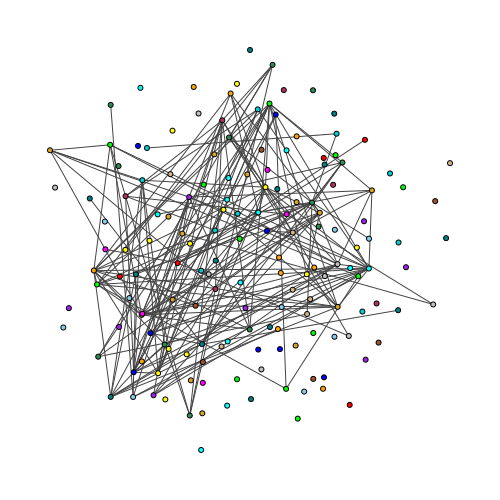

In [53]:
# Plotting the resulting graph
layout = nnd_g.layout_drl()
ig.plot(
    nnd_g, layout=layout,
    bbox=(500,500),
    **{
        "edge_width": np.ceil(np.array(nnd_g.es["weight"]) - 0.985),
        # "edge_width": np.ceil(nnd_g.es["weight"]/max_adj - 0.999936),  # 4*(nnd_g.es["weight"]/max_adj)**2,
        "margin": 50,
        "vertex_size": 5,
        "vertex_label_size": 20,
        "vertex_label_dist": 2
    }
)

In [41]:
# With the above graph, generate sets of "close" flight tests and "far" flight tests for training
close_ft = set()
far_ft = set()

# Iterate over graph edges
threshold = 0.95
for e in nnd_g.es:
    # Check weight threshold
    if e["weight"] >= threshold:
        # Add valid flight tests to close set
        close_ft.add(valid_tf_list[e.source])
        close_ft.add(valid_tf_list[e.target])

# Iterate over all valid test flights
for tf in valid_tf_list:
    if tf not in close_ft:
        far_ft.add(tf)

In [51]:
# Print out the results
print("Number of close flight tests: %i" % len(close_ft))
close_ft_sorted = list(close_ft)
close_ft_sorted.sort(key=lambda x: x[0] + x[1] + str(x[2]))
for ft in close_ft_sorted:
    print("\t%s" % str(ft))
    
print("\nNumber of far flight tests: %i" % len(far_ft))
far_ft_sorted = list(far_ft)
far_ft_sorted.sort(key=lambda x: x[0] + x[1] + str(x[2]))
for ft in far_ft_sorted:
    print("\t%s" % str(ft))
    
print("\n\t\t\tClose\tFar")
print("Average FT Speed:\t%0.2f\t%0.2f" % (
    np.mean(np.array([x[-1] for x in close_ft])),
    np.mean(np.array([x[-1] for x in far_ft]))
))
print("Median FT Speed:\t%0.2f\t%0.2f" % (
    np.median(np.array([x[-1] for x in close_ft])),
    np.median(np.array([x[-1] for x in far_ft]))
))
print("Fraction Constant:\t%0.2f\t%0.2f" % (
    len([x for x in close_ft if "Constant" in x[1]])/len(close_ft),
    len([x for x in far_ft if "Constant" in x[1]])/len(far_ft)
))

Number of close flight tests: 95
	('3dFigure8', 'Constant', 0.5)
	('3dFigure8', 'Constant', 1.0)
	('3dFigure8', 'Constant', 2.0)
	('3dFigure8', 'Constant', 3.0)
	('3dFigure8', 'Constant', 4.0)
	('3dFigure8', 'Constant', 5.0)
	('ampersand', 'Constant', 1.0)
	('ampersand', 'Constant', 2.0)
	('ampersand', 'Constant', 3.0)
	('ampersand', 'Forward', 1.0)
	('bentDice', 'Forward', 0.5)
	('bentDice', 'Forward', 1.0)
	('bentDice', 'Forward', 2.0)
	('bentDice', 'Forward', 3.0)
	('clover', 'Constant', 1.0)
	('clover', 'Forward', 0.5)
	('clover', 'Forward', 1.0)
	('clover', 'Forward', 2.0)
	('clover', 'Forward', 3.0)
	('clover', 'Forward', 4.0)
	('clover', 'Forward', 5.0)
	('dice', 'Constant', 2.0)
	('dice', 'Forward', 1.0)
	('figure8', 'Constant', 0.5)
	('figure8', 'Constant', 1.0)
	('figure8', 'Constant', 2.0)
	('figure8', 'Constant', 3.0)
	('figure8', 'Constant', 5.0)
	('halfMoon', 'Constant', 1.0)
	('halfMoon', 'Constant', 2.0)
	('halfMoon', 'Constant', 3.0)
	('halfMoon', 'Constant', 4.0)
	('h